In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

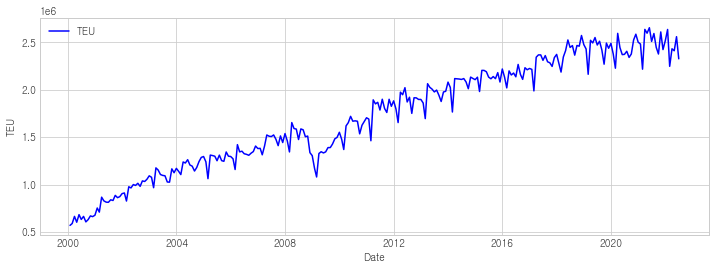

In [6]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='TEU')
plt.legend()

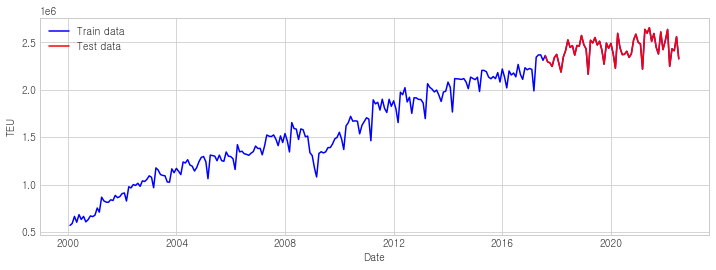

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
seasonal = pd.read_csv('계절성예측.csv')

In [9]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -80
train = raw_df[0:split] 
test = raw_df[split:] 

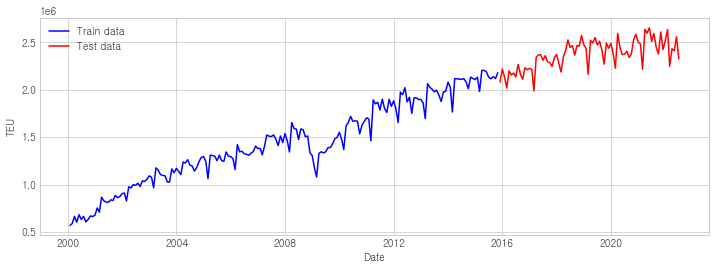

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [17]:
len(train),len(test)

(190, 80)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 20 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 60   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((111, 20, 10), (111, 60, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((1, 20, 10), (1, 60, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal',name='extractor'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())

model.add(RepeatVector(60)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
11/11 [==============================] - 5s 334ms/step - loss: 0.4460 - mae: 0.5839 - val_loss: 0.4504 - val_mae: 0.6140
Epoch 2/200
11/11 [==============================] - 0s 40ms/step - loss: 0.2692 - mae: 0.4401 - val_loss: 0.3243 - val_mae: 0.4942
Epoch 3/200
11/11 [==============================] - 0s 37ms/step - loss: 0.1438 - mae: 0.3038 - val_loss: 0.1588 - val_mae: 0.3254
Epoch 4/200
11/11 [==============================] - 0s 33ms/step - loss: 0.1024 - mae: 0.2578 - val_loss: 0.1583 - val_mae: 0.3406
Epoch 5/200
11/11 [==============================] - 0s 31ms/step - loss: 0.0821 - mae: 0.2284 - val_loss: 0.1284 - val_mae: 0.3003
Epoch 6/200
11/11 [==============================] - 0s 33ms/step - loss: 0.0659 - mae: 0.2056 - val_loss: 0.1255 - val_mae: 0.3081
Epoch 7/200
11/11 [==============================] - 0s 37ms/step - loss: 0.0605 - mae: 0.1948 - val_loss: 0.1527 - val_mae: 0.3413
Epoch 8/200
11/11 [==============================] - 0s 32ms/step - loss: 0

11/11 [==============================] - 0s 33ms/step - loss: 0.0107 - mae: 0.0806 - val_loss: 0.0192 - val_mae: 0.1146


In [28]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

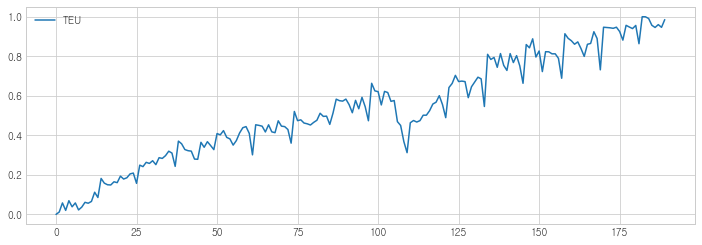

In [29]:
label_train.plot()

<AxesSubplot:>

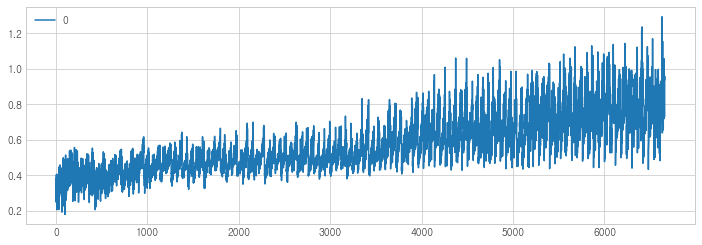

In [30]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 2017.07 ~ 2022.06

In [31]:
X_test_1 = np.array(feature_test.head(20)).reshape((1,20, 10)) 

In [32]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [33]:
dfs = [] # List 
for i in range(30): 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

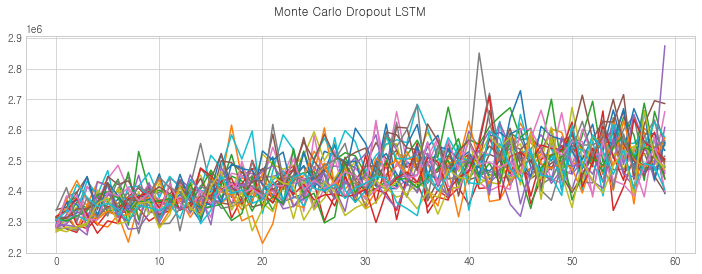

In [34]:
rcParams['figure.figsize'] = 12, 4
plt.suptitle('Monte Carlo Dropout LSTM')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [35]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [36]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [37]:
#df.to_csv('60개월1.csv')

### 전체 인덱스 

In [38]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2317808.0,2304661.0,2281540.75,2308442.25,2280462.25,2294563.25,2266646.5,2286689.25,2272825.5,2313815.25,2289457.25,2313639.75,2311252.25,2302279.5,2288623.0,2340109.0,2312329.0,2280879.75,2267522.5,2307652.75,2306174.0,2307074.25,2315464.0,2318264.0,2285360.25,2314336.5,2283466.0,2336985.25,2276552.25,2306825.5


In [39]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


### Epistemic Uncertainty

Mean RMSE: 111060.21707607732
Mean MAPE: 3.705538132705557


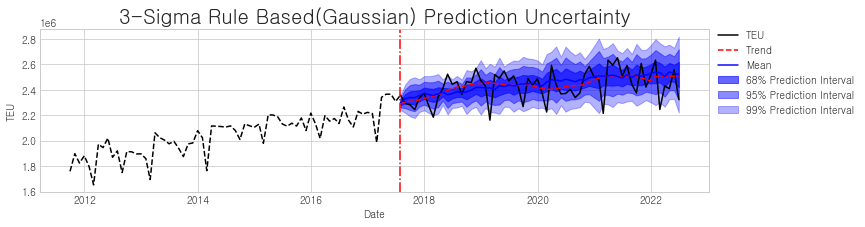

In [40]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='blue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='blue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().mean())/ test_data.reset_index()['TEU'])*100) )

Median RMSE: 109749.73285256495
Median MAPE: 3.6648081175550136


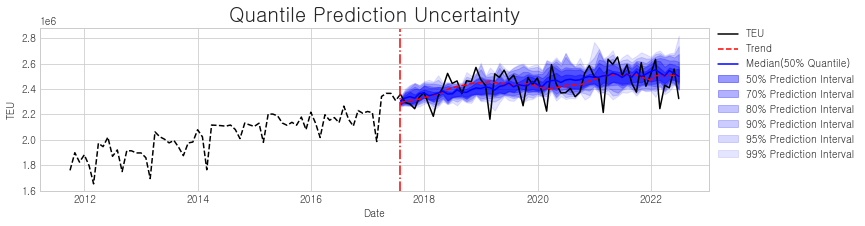

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='blue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='blue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='blue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='blue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='blue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='blue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.reset_index()['TEU'])*100) )

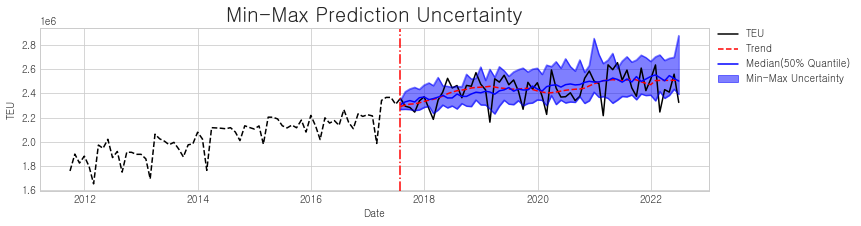

In [106]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')


plt.plot(df2.transpose().min(),color='blue', alpha=0.5)
plt.plot(df2.transpose().max(),color='blue', alpha=0.5)
plt.fill_between(df2.transpose().median().index, df2.transpose().min(),df2.transpose().max(), alpha=0.5,color='blue', label='Min-Max Uncertainty')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [42]:
from scipy.ndimage import zoom

In [43]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32) # TensorShape([1, 5, 7]) 3차원 텐서 변환. / 입력값 X 정의

    with tf.GradientTape() as tape: # Y = aX 식 정의 
        predictions = model(seq) # predictions -> Y / seq --> X 

    grad = tape.gradient(predictions, seq) # dy/dx 정의. X에 대한 Y의 변화. 입력값에 대한 출력값의 변화. Time Step별 기울기
    grad = tf.reduce_mean(grad, axis=1).numpy()[0] # Time Step별 미분계수 평균
    
    return grad # 결과 출력

In [44]:
def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

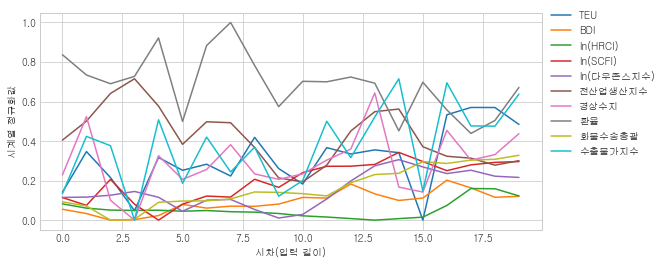

In [60]:
plt.figure(figsize=(9,4))
plt.plot(X_test[0]) # 테스트 입력 시퀀스 
plt.ylabel('시계열 정규화값'); plt.xlabel('시차(입력 길이)')
plt.legend(train.columns,bbox_to_anchor=(1.0, 1.05), loc="upper left")
plt.show()

In [61]:
grad_imp = gradient_importance(X_test[0],model) # 편미분계수 크기 (기울기 크기 )

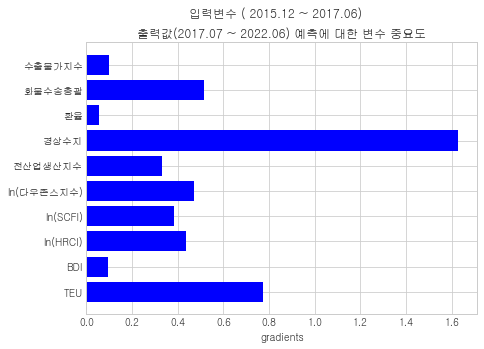

In [63]:
plt.figure(figsize=(7,5))
plt.barh(range(len(grad_imp)), np.abs(grad_imp),color='blue')
plt.yticks(range(len(train.columns)), train.columns)
plt.xlabel('gradients')
plt.title('출력값(2017.07 ~ 2022.06) 예측에 대한 변수 중요도')
plt.suptitle('입력변수 ( 2015.12 ~ 2017.06)')
plt.show()

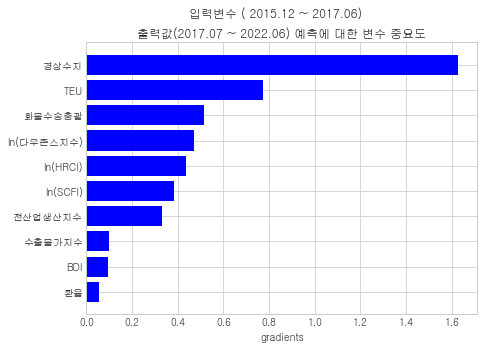

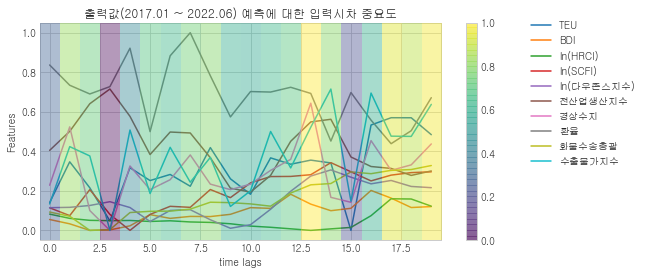

In [94]:
plt.figure(figsize=(7,5))
plt.barh(range(len(grad_imp)), np.sort(np.abs(grad_imp)),color='blue')
plt.yticks(range(len(train.columns)),['환율','BDI','수출물가지수','전산업생산지수','ln(SCFI)','ln(HRCI)','ln(다우존스지수)','화물수송총괄','TEU','경상수지'])
plt.xlabel('gradients')
plt.title('출력값(2017.07 ~ 2022.06) 예측에 대한 변수 중요도')
plt.suptitle('입력변수 ( 2015.12 ~ 2017.06)')
plt.show()

activation = activation_grad(X_test[0],model)
plt.figure(figsize=(9,4))
plt.plot(X_test[0])
plt.legend(train.columns,bbox_to_anchor=(1.20, 1.05), loc="upper left")
plt.ylabel('Features'); plt.xlabel('time lags')
plt.title('출력값(2017.01 ~ 2022.06) 예측에 대한 입력시차 중요도')
plt.twinx()
plt.imshow(np.vstack([activation]*50), alpha=0.4)
plt.axis('off')
plt.colorbar()
plt.set_cmap('viridis')